### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

### Importing Data

In [28]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Combining both train and test data sets into one, to perform feature engineering and then divide them later again.
#Adding ‘source’ column specifying where each observation belongs.
train['source'] = 'train'
test['source'] = 'test'

data = pd.concat([train, test], sort = False)
data.shape

(14204, 13)

### Data Exploration

##### 1. Checking which columns contain missing values.

In [30]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

##### 2. Checking basic statistics for numerical variables.

In [31]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


NOTE: Item_Visibility has a min value of zero. 
Strange, when a product is being sold in a store, the visibility cannot be 0

##### 3. Checking the number of unique values in each feature.

In [41]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

NOTE: 1559 different products with 10 different stores

##### 4. Getting the names of categorical and numerical columns

In [54]:
# Categorical column names
categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
#Excluding ID columns and source column
categorical_columns = [col for col in categorical_columns if col not in ['Item_Identifier', 'Outlet_Identifier', 'source']]

# Numerical column names
numerical_columns = [col for col in data.columns if data[col].dtype != 'object']

##### 5. Checking the frequencies of each categorical feature

In [64]:
print('FREQUENCY OF CATEGORIES FOR EACH CATEGORICAL FEATURE:\n')
print('-------------------------------------------')
for col in categorical_columns:
    print(data[col].value_counts())
    print('-------------------------------------------')

FREQUENCY OF CATEGORIES FOR EACH CATEGORICAL FEATURE:

-------------------------------------------
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
-------------------------------------------
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
-------------------------------------------
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64
-------------------------------------------
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Locatio

NOTES:
1. Item_Fat_Content: ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’ and ‘Regular’ mis-coded with 'reg'
2. Item_Type: Some categories can be combined

### Data Cleaning

##### 1. Imputing Missing Values in 'Item_Weight' and 'Outlet_Size' features

In [268]:
X = data.drop('Item_Outlet_Sales', axis = 1)
y = data['Item_Outlet_Sales']

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X))

#Imputation removes column names, putting them back
X_imputed.columns = X.columns

#Imputation removes indexes, putting them back
X_imputed.index = X.index

#Making sure that there are no missing values.
X_imputed.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
source                       0
dtype: int64

##### 2. Removing Outliers

In [95]:
# All numerical columns without y
print(numerical_columns[:-1])

#Deciding lower and upper bound for outliers
lower_bound = 0.1
upper_bound = 0.95

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']


##### 2.1. Item_Weight column

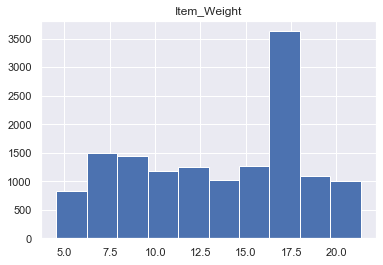

0.10    6.92
0.95    20.1
Name: Item_Weight, dtype: object

In [270]:
plt.hist(X_imputed.Item_Weight)
plt.title('Item_Weight')
plt.show()
res = X_imputed.Item_Weight.quantile([lower_bound, upper_bound])
res

NOTE: Getting values anything more than 6.92  

In [271]:
print('Length Before:', len(X_imputed))

#Removing Outliers
X_imputed_out_1 = X_imputed[X_imputed.Item_Weight.values > res[lower_bound]]

print('Length After:', len(X_imputed_out_1))

Length Before: 14204
Length After: 12772


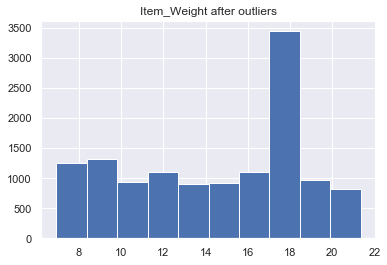

In [273]:
plt.hist(X_imputed_out_1.Item_Weight)
plt.title('Item_Weight after outliers')
plt.show()

##### 2.2. Item_Visibility column

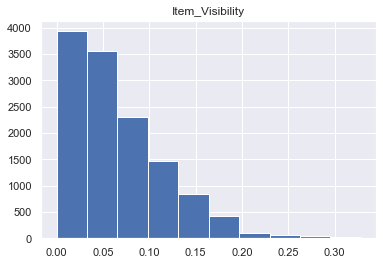

In [274]:
plt.hist(X_imputed_out_1.Item_Visibility)
plt.title('Item_Visibility')
plt.show()

##### Replacing 0 values with the mean of it

In [275]:
Item_Visibility_mean_value = X_imputed_out_1.Item_Visibility.mean()
Item_Visibility = X_imputed_out_1.Item_Visibility.replace(0, Item_Visibility_mean_value)
X_imputed_out_1['Item_Visibility'] = Item_Visibility

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##### 2.3. Item_MRP column

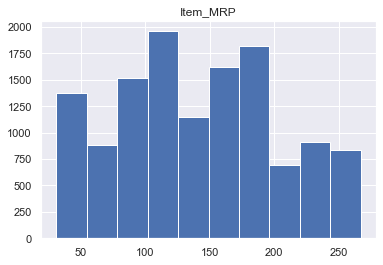

0.10    52.8956
0.95    249.009
Name: Item_MRP, dtype: object

In [277]:
plt.hist(X_imputed_out_1.Item_MRP)
plt.title('Item_MRP')
plt.show()

res2 = X_imputed_out_1.Item_MRP.quantile([lower_bound, upper_bound])
res2

NOTE: Getting values more than 52.8956 and less than 249.009

In [278]:
print('Length Before:', len(X_imputed_out_1))

#Removing Outliers
X_imputed_out_2 = X_imputed_out_1[(X_imputed_out_1.Item_MRP.values > res2[lower_bound]) & (X_imputed_out_1.Item_MRP.values < res2[upper_bound])]

print('Length After:', len(X_imputed_out_2))

Length Before: 12772
Length After: 10855


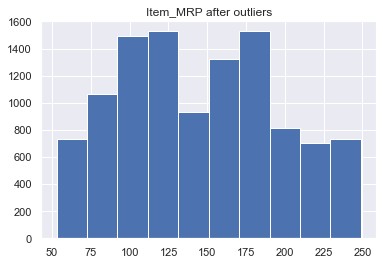

In [279]:
plt.hist(X_imputed_out_2.Item_MRP)
plt.title('Item_MRP after outliers')
plt.show()

NOTE: Looking more like Normaly distributed

##### 2.4. Outlet_Establishment_Year column

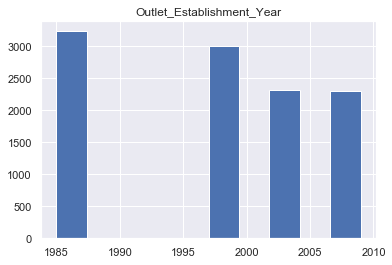

0.10    1985
0.95    2009
Name: Outlet_Establishment_Year, dtype: object

In [280]:
plt.hist(X_imputed_out_2.Outlet_Establishment_Year)
plt.title('Outlet_Establishment_Year')
plt.show()

res3 = X_imputed_out_2.Outlet_Establishment_Year.quantile([lower_bound, upper_bound])
res3

In [281]:
#Unique years
X_imputed_out_2.Outlet_Establishment_Year.unique()

array([1999, 1998, 1987, 1985, 2002, 2007, 1997, 2009, 2004], dtype=object)

NOTE: There is no need to remove, due to the fact that there is no store established before 1985 and after 2009

### Feature Engineering

#### 1. Item_Type column

###### 1.1. Creating a broad category of Type of Item

In [282]:
print(X_imputed_out_2.Item_Type.unique(), '\nSize:',len(X_imputed_out_2.Item_Type.unique()))

['Meat' 'Fruits and Vegetables' 'Household' 'Snack Foods' 'Frozen Foods'
 'Dairy' 'Breakfast' 'Health and Hygiene' 'Hard Drinks' 'Baking Goods'
 'Breads' 'Soft Drinks' 'Canned' 'Starchy Foods' 'Others' 'Seafood'] 
Size: 16


NOTE: There are 16 types of producs we can make only 3 categories: Food, Drinks, Others

In [283]:
# Creating new column with combined type

#Creating new column 'Combined_Item_Type' with first two letters of 'Item_Identifier' column,
# which FD, DR and NC corespondents to Food, Drinks and Others respectively
X_imputed_out_2['Combined_Item_Type'] = X_imputed_out_2.Item_Identifier.apply(lambda x: x[:2])

#Replacing ['FD', 'NC', 'DR'], ['Food', 'Others', 'Drinks'] respectively of 'Combined_Item_Type' column
X_imputed_out_2.Combined_Item_Type = X_imputed_out_2.Combined_Item_Type.replace(['FD', 'NC', 'DR'], ['Food', 'Others', 'Drinks'])
X_imputed_out_2.head()

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,source,Combined_Item_Type
2,FDN15,17.5,Low Fat,0.016760,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,train,Food
3,FDX07,19.2,Regular,0.066285,Fruits and Vegetables,182.095,OUT010,1998,Medium,Tier 3,Grocery Store,train,Food
4,NCD19,8.93,Low Fat,0.066285,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,train,Others
6,FDO10,13.65,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,train,Food
7,FDP10,17.6,Low Fat,0.127470,Snack Foods,107.762,OUT027,1985,Medium,Tier 3,Supermarket Type3,train,Food


#### 2. Outlet_Establishment_Year column

##### 2.1. New column with the years of operation of a store

In [284]:
# Due to the fact data is collected in 2013, I am gonna get latest year as 2013
# Creating new column 'Years_of_operation'
X_imputed_out_2['Years_of_operation'] = 2013 - X_imputed_out_2.Outlet_Establishment_Year
X_imputed_out_2.head()

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,source,Combined_Item_Type,Years_of_operation
2,FDN15,17.5,Low Fat,0.016760,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,train,Food,14
3,FDX07,19.2,Regular,0.066285,Fruits and Vegetables,182.095,OUT010,1998,Medium,Tier 3,Grocery Store,train,Food,15
4,NCD19,8.93,Low Fat,0.066285,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,train,Others,26
6,FDO10,13.65,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,train,Food,26
7,FDP10,17.6,Low Fat,0.127470,Snack Foods,107.762,OUT027,1985,Medium,Tier 3,Supermarket Type3,train,Food,28


#### 3. Item_Fat_Content column

##### 3.1. Correcting mis-coded values ('LF', 'reg', 'low fat') to 'Low Fat' and 'Regular' 

In [285]:
X_imputed_out_2.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'LF', 'reg', 'low fat'], dtype=object)

In [286]:
Item_Fat_Content = X_imputed_out_2['Item_Fat_Content'].replace(['low fat', 'LF'], 'Low Fat')
Item_Fat_Content = Item_Fat_Content.replace('reg', 'Regular')
X_imputed_out_2['Item_Fat_Content'] = Item_Fat_Content
X_imputed_out_2['Item_Fat_Content'].unique()

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array(['Low Fat', 'Regular'], dtype=object)

#### 3.2. Changing Item_Fat_Content to 'Low Fat', 'Regular' and 'Non-Edible'

In [287]:
X_imputed_out_2.loc[X_imputed_out_2['Combined_Item_Type'] == 'Others', 'Item_Fat_Content'] = 'Non-Edible'
X_imputed_out_2.head()

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,source,Combined_Item_Type,Years_of_operation
2,FDN15,17.5,Low Fat,0.016760,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,train,Food,14
3,FDX07,19.2,Regular,0.066285,Fruits and Vegetables,182.095,OUT010,1998,Medium,Tier 3,Grocery Store,train,Food,15
4,NCD19,8.93,Non-Edible,0.066285,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,train,Others,26
6,FDO10,13.65,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,train,Food,26
7,FDP10,17.6,Low Fat,0.127470,Snack Foods,107.762,OUT027,1985,Medium,Tier 3,Supermarket Type3,train,Food,28


#### 4. Categorical Encoding

In [288]:
# Making new column 'Outlet' for Label Encoding
X_imputed_out_2['Outlet'] = X_imputed_out_2.Outlet_Identifier

# Droping Product and Store Identifier columns and 'source' column, as well as Item_Type, Outlet_Establishment_Year because I made new broaded feature of it
X_imputed_outlied_featured = X_imputed_out_2.drop(['Item_Identifier', 'Outlet_Identifier', 'source', 'Item_Type', 'Outlet_Establishment_Year'], axis = 1)

X_imputed_outlied_featured.head()

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Combined_Item_Type,Years_of_operation,Outlet
2,17.5,Low Fat,0.016760,141.618,Medium,Tier 1,Supermarket Type1,Food,14,OUT049
3,19.2,Regular,0.066285,182.095,Medium,Tier 3,Grocery Store,Food,15,OUT010
4,8.93,Non-Edible,0.066285,53.8614,High,Tier 3,Supermarket Type1,Others,26,OUT013
6,13.65,Regular,0.012741,57.6588,High,Tier 3,Supermarket Type1,Food,26,OUT013
7,17.6,Low Fat,0.127470,107.762,Medium,Tier 3,Supermarket Type3,Food,28,OUT027


In [289]:
# Categorical column names to encode
categ_cols = ['Item_Fat_Content', 'Outlet_Size','Outlet_Location_Type', 'Outlet_Type','Combined_Item_Type','Outlet']

#Encoding Categorical columns
X_categorical_encoded = pd.get_dummies(X_imputed_outlied_featured[categ_cols], drop_first = True)

#Getting numerical_columns only
numerical_columns = X_imputed_outlied_featured.drop(categ_cols, axis =1)

#Concatinating Numerical and categorical columns
X_imputed_outlied_featured_encoded = pd.concat([numerical_columns, X_categorical_encoded], axis = 1)
X_imputed_outlied_featured_encoded

,Item_Weight,Item_Visibility,Item_MRP,Years_of_operation,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,...,Combined_Item_Type_Others,Outlet_OUT013,Outlet_OUT017,Outlet_OUT018,Outlet_OUT019,Outlet_OUT027,Outlet_OUT035,Outlet_OUT045,Outlet_OUT046,Outlet_OUT049
2,17.5,0.016760,141.618,14,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,19.2,0.066285,182.095,15,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8.93,0.066285,53.8614,26,1,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
6,13.65,0.012741,57.6588,26,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
7,17.6,0.127470,107.762,28,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,10.5,0.013496,141.315,16,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5677,7.6,0.142991,169.145,4,0,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
5678,10,0.073529,118.744,11,1,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
5679,15.3,0.066285,214.622,6,0,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0


#### 5. Final data munging before modeling

In [299]:
#Adding 'source' column, so it can be divided into train and test data frame
X_imputed_outlied_featured_encoded_1 = pd.concat([X_imputed_outlied_featured_encoded, X_imputed_out_2.source], axis = 1)

#Getting train data set and droping 'source' column
train_data = X_imputed_outlied_featured_encoded_1[X_imputed_outlied_featured_encoded_1.source == 'train'].drop('source', axis = 1)

#Getting test data set and droping 'source' column
test_data = X_imputed_outlied_featured_encoded_1[X_imputed_outlied_featured_encoded_1.source == 'test'].drop('source', axis = 1)

In [313]:
#Modifying dependent variable y, due to the fact removing indexes in feature engineering
new_y = y.dropna()
new_y1 = set(new_y.index)
new_y11 = list()
new_y2 = new_y1 - set(train_data.index)
new_y3 = list(new_y2)
new_y4 = new_y.drop(new_y3)

new_y4

2       2097.2700
3        732.3800
4        994.7052
6        343.5528
7       4022.7636
          ...    
8517    3608.6360
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 6516, dtype: float64

#### 6. Checking Correlations and Feature Selection

##### 6.1. Correlations

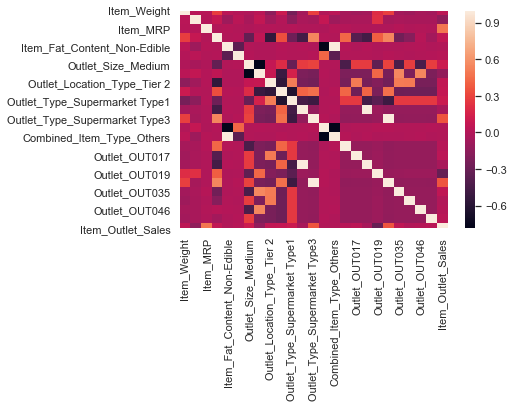

In [334]:
#Converting some object type feature into numeric

## Converting each object feature into numeric
Item_Weight = pd.to_numeric(train_data.Item_Weight)
Item_MRP = pd.to_numeric(train_data.Item_MRP)
Years_of_operation = pd.to_numeric(train_data.Years_of_operation)

#Assigning new object
X_train_data = train_data.copy()

# Changint object features with numeric
X_train_data.Item_Weight = Item_Weight
X_train_data.Item_MRP = Item_MRP
X_train_data.Years_of_operation = Years_of_operation

#Concatinating final ready data with predictions to check correlations between them
train_data_test = pd.concat([X_train_data, new_y4], axis = 1)

correlation = train_data_test.corr()

sns.heatmap(correlation)

##### 6.2. Feature Selection

In [414]:
## Automatic Backward Elimination Function
# param x_ is independent values in pandas dataframe
# param y_ is dependent value pandas series
# param sl_ is significant level
# return eliminated columns with less than significante level in pandas dataframe
#
def backwardElimination(x_, y_, sl_):
    
    for i in range(len(x_.columns)): # in range of the size of columns
        x_test = sm.add_constant(x_) # adding constant to the dataframe for calculations
        results = sm.OLS(y_,x_test).fit() # fitting the model using statsmodels
        #results.summary() # summary descriptions of the model
        
        max_p_value = max(results.pvalues) # getting the maxiumum p-value from all columns
        
        if max_p_value > sl_: # if maximum p-value is more than significante level
            column_to_drop = results.pvalues.idxmax() # assigning column name to variable using 'idxmax()' method, so it can be drop
            x_ = x_.drop(column_to_drop, axis = 1) # dropping column
    return x_

#Getting only optimum features 
X_optim = backwardElimination(X_train_data, new_y4, 0.01)
X_optim

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Item_MRP,Years_of_operation,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_OUT013,Outlet_OUT018,Outlet_OUT019,Outlet_OUT027,Outlet_OUT049
2,141.6180,14,1,0,0,1,0,0,0,0,0,0,1
3,182.0950,15,1,0,1,0,0,0,0,0,0,0,0
4,53.8614,26,0,0,1,1,0,0,1,0,0,0,0
6,57.6588,26,0,0,1,1,0,0,1,0,0,0,0
7,107.7622,28,1,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517,178.8318,16,0,1,0,1,0,0,0,0,0,0,0
8519,108.1570,11,1,0,0,1,0,0,0,0,0,0,0
8520,85.1224,9,0,1,0,1,0,0,0,0,0,0,0
8521,103.1332,4,1,0,1,0,1,0,0,1,0,0,0


### Modeling

#### 1. Linear Regression

In [345]:
def score(X, y):
    # Splitting dataset into Training and Test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    # Fitting Multiple Linear Regression to the Training set
    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    prediction  = regressor.predict(X_test)
    
    #Result of RMSE
    from sklearn import metrics
    result  = np.sqrt(metrics.mean_squared_error(y_test, prediction))
    
    return result

#Scoring
score(X_optim, new_y4)
# 1121.394251336875

1121.394251336875

#### 2. Polynomial Regression

In [415]:
def poly_score(X, y, degree):
    import numpy as np
    
    # Splitting dataset into Training and Test set
    from sklearn.model_selection import train_test_split
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    from sklearn.preprocessing import PolynomialFeatures
    poly_reg = PolynomialFeatures(degree=degree)
    X_poly1 = poly_reg.fit_transform(X_train1)
    
    # Fitting Multiple Linear Regression to the Training set
    from sklearn.linear_model import LinearRegression    
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly1, y_train1)
    
    prediction = lin_reg.predict(poly_reg.fit_transform(X_test1))
    
    #Result of RMSE
    from sklearn import metrics
    result  = np.sqrt(metrics.mean_squared_error(y_test1, prediction))
    
    return result

#Scoring
poly_score(X_optim, new_y4, 2)

1077.5153790327213

#### 3. Support Vector Regression

In [352]:
def svr_score(X, y):
    
    # Feature Scaling
    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    
    X_sc = sc_X.fit_transform(X)
    y_sc = sc_y.fit_transform(y.values.reshape(-1,1))
    
    # Splitting dataset into Training and Test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_sc, y_sc, test_size = 0.2, random_state = 1)
    
    # Reshaping X and y to make 2D array
    #X1 = X.values.reshape(-1,1)
    #y1 = y.values.reshape(-1,1)
    
    
    # Fitting SVR to the dataset
    from sklearn.svm import SVR
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train,y_train)
    
    # Predicting a new result
    prediction = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)))
    
    #Result of RMSE
    from sklearn import metrics
    result  = np.sqrt(metrics.mean_squared_error(y_test, prediction))
    
    return result

#Scoring
svr_score(X_optim, new_y4)

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


2168.684832410549

#### 4. Random Forest Regression

In [404]:
def random_forest_score(X, y):
    
    # Splitting dataset into Training and Test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    # Fitting Random Forest Regression to the dataset
    from sklearn.ensemble import RandomForestRegressor
    regressor = RandomForestRegressor(n_estimators = 70, random_state = 1, max_depth=5, min_samples_leaf=30)
    regressor.fit(X_train, y_train)
    
    # Predicting a new result
    prediction = regressor.predict(X_test)
    
    #Result of RMSE
    from sklearn import metrics
    result  = np.sqrt(metrics.mean_squared_error(y_test, prediction))
    
    return result

#Scoring
random_forest_score(X_optim, new_y4)


1084.5714688943247

#### 5. XGBoost

In [374]:
def xgboost(X, y):
    
    # Splitting dataset into Training and Test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    import xgboost as xgb
    model = xgb.XGBRegressor(max_depth=4, n_estimators=60, learning_rate=0.09)

    model.fit(X_train,y_train)
    
    prediction = model.predict(data=X_test)
    
    #Result of RMSE
    from sklearn import metrics
    result  = np.sqrt(metrics.mean_squared_error(y_test, prediction))
    
    return result

#Scoring
xgboost(X_optim, new_y4)

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:20:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1091.290626331137

NOTE: The Best Scores:
1. Polynomial Regression:       1077.517832206261
2. Random Forest Regression:    1084.5714688943247
3. XGBoost:                     1091.290626331137
4. Linear Regression:           1121.394251336875
5. Support Vector Regression:   2168.684832410549

### Predicting Test Data

#### Choosing the best Model score - Polynomial Regression

In [429]:

import numpy as np
    
# Splitting dataset into Training and Test set
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train_data, new_y4, test_size = 0.2, random_state = 1)
    
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly1 = poly_reg.fit_transform(X_train1)
    
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression    
lin_reg = LinearRegression(normalize = True)
lin_reg.fit(X_poly1, y_train1)
    
prediction = lin_reg.predict(poly_reg.fit_transform(X_test1))
    
#Result of RMSE
    
from sklearn import metrics
result  = np.sqrt(metrics.mean_squared_error(y_test1, prediction))

result

1084.4816665297728

In [436]:
#Predicting Test data
test_prediction = lin_reg.predict(poly_reg.transform(test_data))
len(test_prediction)

4339

In [437]:
#Define a dataframe with IDs for submission:
base0 = X_imputed_out_2[X_imputed_out_2.source == 'test']
base1 = base0[['Item_Identifier', 'Outlet_Identifier']]
base1['Item_Outlet_Sales'] = test_prediction

#Export submission file
base1.to_csv("Big_Mart_Predictions.csv",index=False)

/Users/berayhayrulah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
